In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 14.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.56-py2.py3-none-any.whl size=22627 sha256=0c6ea556c438dafb98f0d3ee95421632642a6df9c4c9527fa25594e66f428200
  Stored in directory: /root/.cache/pip/wheels/e9/26/69/ebde3c87490e75c5d8b06cf2dd284d1183ca1bb814b1d5f18c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, LeakyReLU, BatchNormalization, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
DRIVE = '/content/drive/MyDrive/Colab Notebooks'

Mounted at /content/drive


# Préparation de données
type de prévision : classification<br>
type de représentation de données : signes( +, -, 0)<br>
Architecture NN: 2 layers of LSTM model and dense output layer with RELU activation<br>



In [ ]:
def raw_data(cols):
    return pd.DataFrame(yf.download("^GSPC")[cols].dropna())

def log_return(cols):
    log_data = np.log(raw_data(cols))
    return log_data.diff().dropna()

def get_sign(df):
    df[(df > -1e-4) & (df < 1e-4)] = 0
    df[df > 0] = 1
    df[df < 0] = -1
    return df

In [ ]:
#split a univariate sequence into samples
def split_sequence_univariate(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# split a multivariate sequence into samples
def split_sequences_multivariate(sequences, n_steps):
    sequences = sequences.reshape((len(sequences), -1))
    X, y = list(), list()
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
# gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y.flatten())
    return np.array(X), np.array(y)


def train_test_set(df, len_seq, batch, test_in_batch=False):
    train_len = int(len(df) * 0.8)
    train_set = df.iloc[:train_len, :].values
    test_set = df.iloc[train_len:, :].values
    train_x, train_y = split_sequences_multivariate(train_set, len_seq)
    test_x, test_y = split_sequences_multivariate(test_set, len_seq)

    train_x, train_y = train_x[:batch * (len(train_x) // batch)], train_y[:batch * (len(train_y) // batch)]
    batches = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(train_x.shape[0]).batch(batch)

    print('train batch: %s*%s, train set shape: %s, train target shape: %s' %
          (batch, len(train_x) // batch, train_x.shape, train_y.shape))
    if test_in_batch:
        test_x, test_y = test_x[:batch * (len(test_x) // batch)], test_y[:batch * (len(test_y) // batch)]
        test_batches = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(batch)
        print('test batch: %s*%s, test set shape: %s, test target shape: %s' % 
              (batch, len(test_x) // batch, test_x.shape, test_y.shape))
        return batches, test_batches, None


    print('test set shape: %s, test target shape: %s' % (test_x.shape, test_y.shape))
    return batches, test_x, test_y


def run_lstm(dataset, len_seq, units, epochs, batch):
    with tf.device('/device:GPU:0'):
        train_batch, test_x, test_y = train_test_set(dataset, len_seq, batch)

        model = Sequential([
            # Shape [batch, time, features] => [batch, time, lstm_units]
            LSTM(units, input_shape=(len_seq,test_x.shape[-1]), return_sequences=True),
            LSTM(units,  return_sequences=False),
            # Shape => [batch, time, features]
            Dense(3, activation='relu'),
            Dense(1)
        ])
        # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
        #                                                 patience=patience,
        #                                                 mode='min')

        model.compile(loss=tf.losses.MeanSquaredError(),
                        optimizer=tf.optimizers.Adam(),
                        metrics=[tf.metrics.MeanAbsoluteError()])
        print(model.summary())

        history = model.fit(train_batch, epochs=epochs, verbose=0)
                            # callbacks=[early_stopping])
        print('*** model training done ***')
        
        plt.plot(history.history['loss'])
        plt.xlabel('epoch')
        plt.ylabel('mse')
        plt.show()

        # to do : use test set to calculate metrics
        return model, test_x, test_y

[*********************100%***********************]  1 of 1 completed


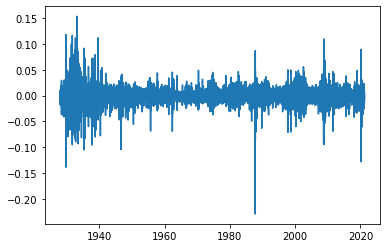

,Adj Close
Date,
1928-01-03,1.0
1928-01-04,-1.0
1928-01-05,-1.0
1928-01-06,1.0
1928-01-09,-1.0
...,...
2021-03-18,-1.0
2021-03-19,-1.0
2021-03-22,1.0


In [ ]:
adjclose_ret = log_return('Adj Close') # dataframe
plt.plot(adjclose_ret)
plt.show()
adjclose_ret = get_sign(adjclose_ret)
adjclose_ret

# 1 Rendement seuls

train batch: 64*291, train set shape: (18624, 100, 1), train target shape: (18624, 1)
test set shape: (4584, 100, 1), test target shape: (4584, 1)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 128)          66560     
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 387       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 4         
Total params: 198,535
Trainable params: 198,535
Non-trainable params: 0
_________________________________________________________________
None
*** model training done ***


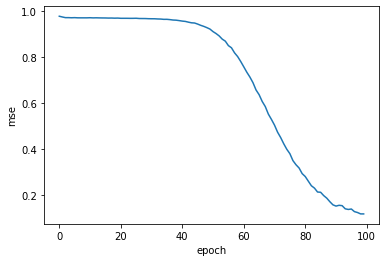

In [ ]:
LSTM1, TX1, TY1 = run_lstm(adjclose_ret,
                         len_seq=100, units=128, epochs=100, batch=64)

In [ ]:
PRED1 = np.sign(LSTM1(TX1, training=False).numpy().flatten())
print(np.sign(PRED1))
print(np.sum(PRED1 == TY1.flatten()) / len(PRED1))
# plt.plot(TY, label='actual', alpha=0.7)
# plt.plot(PRED, label='predict')
# plt.legend()

[ 1.  1.  1. ... -1.  1. -1.]
0.50021815008726


[result]: We can get a precision of 50.02% on test set.

# 2 Rendements et OHLC


In [ ]:
def data_with_log_ratio():
    data = raw_data(['Open', 'Close', 'High', 'Low'])
    res = get_sign(log_return('Adj Close'))
    data['logHO'] = np.ma.log(data['High'].values / data['Open'].values).filled(0)
    data['logLO'] = np.ma.log(data['Low'].values / data['Open'].values).filled(0)
    data['logCO'] = np.ma.log(data['Close'].values / data['Open'].values).filled(0)
    data = data[['logHO','logLO','logCO']]
    data = data[(data.T != 0).any()]
    # data=(data-data.mean())/data.std()
    return pd.merge(res, data, left_index=True, right_index=True)

In [ ]:
data_log_ratio = data_with_log_ratio()

train batch: 64*121, train set shape: (7744, 100, 4), train target shape: (7744, 1)
test set shape: (1863, 100, 4), test target shape: (1863, 1)
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 100, 128)          68096     
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 387       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 4         
Total params: 200,071
Trainable params: 200,071
Non-trainable params: 0
_________________________________________________________________
None
*** model training done ***


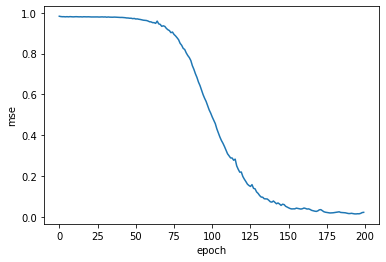

In [ ]:
LSTM2, TX2, TY2 = run_lstm(data_log_ratio,
                         len_seq=100, units=128, epochs=200, batch=64)


In [ ]:
PRED2 = np.sign(LSTM2(TX2, training=False).numpy().flatten())
print(np.sign(PRED2))
print(np.sum(PRED2 == TY2.flatten()) / len(PRED2))

[-1. -1. -1. ...  1. -1. -1.]
0.5077831454643049


[result]: We can get a precision of 50.78% on test set.

## 2.bis Rendements et signes de OHLC


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
            Adj Close  logHO  logLO  logCO
Date                                      
1982-04-20       -1.0    1.0   -1.0   -1.0
1982-04-21        1.0    1.0   -1.0    1.0
1982-04-22        1.0    1.0    0.0    1.0
1982-04-23        1.0    1.0   -1.0    1.0
1982-04-26        1.0    1.0   -1.0    1.0
...               ...    ...    ...    ...
2021-03-18       -1.0    1.0   -1.0   -1.0
2021-03-19       -1.0    1.0   -1.0    0.0
2021-03-22        1.0    1.0   -1.0    1.0
2021-03-23       -1.0    1.0   -1.0   -1.0
2021-03-24       -1.0    1.0   -1.0   -1.0

[9815 rows x 4 columns]
train batch: 64*121, train set shape: (7744, 100, 4), train target shape: (7744, 1)
test set shape: (1863, 100, 4), test target shape: (1863, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 100, 128)          68096     
_________________________________________________________________
lstm_27 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 387       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 4         
Total params: 200,071
Trainable params: 200,071
Non-trainable params: 0
_________________________________________________________________
None
*** model training done ***


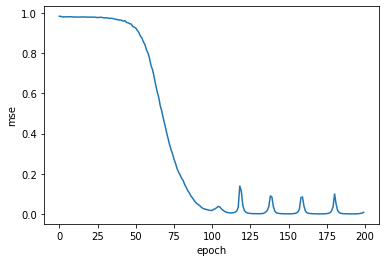

[1. 1. 1. ... 1. 1. 1.]
0.5104669887278583


In [ ]:
def data_with_log_ratio_sign():
    data = raw_data(['Open', 'Close', 'High', 'Low'])
    res = get_sign(log_return('Adj Close'))
    data['logHO'] = np.ma.log(data['High'].values / data['Open'].values).filled(0)
    data['logLO'] = np.ma.log(data['Low'].values / data['Open'].values).filled(0)
    data['logCO'] = np.ma.log(data['Close'].values / data['Open'].values).filled(0)
    data = data[['logHO','logLO','logCO']]
    data = data[(data.T != 0).any()]
    data = get_sign(data)
    # data=(data-data.mean())/data.std()
    return pd.merge(res, data, left_index=True, right_index=True)

data_log_ratio_sign = data_with_log_ratio_sign()
print(data_log_ratio_sign)
LSTM2c, TX2c, TY2c = run_lstm(data_log_ratio_sign,
                         len_seq=100, units=128, epochs=200, batch=64)
PRED2c = np.sign(LSTM2c(TX2c, training=False).numpy().flatten())
print(np.sign(PRED2c))
print(np.sum(PRED2c == TY2c.flatten()) / len(PRED2c))

[result]: We can get a precision of 51.05% on test set.

# 3 Rendement, OHLC et volume

In [ ]:
def data_ratio_volume():
    data_lr = data_with_log_ratio()
    
    data = raw_data('Volume')
    data['Volume'] = np.ma.log(data['Volume'].values).filled(0)
    # data.plot()
    # data=(data-data.mean())/data.std()
    return pd.merge(data_lr, data, left_index=True, right_index=True)

In [ ]:
data_full = data_ratio_volume()

print(data_full)
# data_full['Volume'].plot()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


[*********************100%***********************]  1 of 1 completed
            Adj Close     logHO     logLO     logCO     Volume
Date                                                          
1982-04-20       -1.0  0.011505 -0.008412 -0.003114  17.815728
1982-04-21        1.0  0.003372 -0.001560  0.002076  17.872845
1982-04-22        1.0  0.013135  0.000000  0.012623  17.981711
1982-04-23        1.0  0.005240 -0.007058  0.005240  18.089952
1982-04-26        1.0  0.003274 -0.005818  0.002687  17.918154
...               ...       ...       ...       ...        ...
2021-03-18       -1.0  0.004069 -0.010844 -0.009668  22.120295
2021-03-19       -1.0  0.004330 -0.006767 -0.000010  22.767734
2021-03-22        1.0  0.009866 -0.000593  0.006137  22.184524
2021-03-23       -1.0  0.002924 -0.009192 -0.006901  22.259130
2021-03-24       -1.0  0.005635 -0.007904 -0.007886  21.605706

[9815 rows x 5 columns]


train batch: 64*121, train set shape: (7744, 100, 5), train target shape: (7744, 1)
test set shape: (1863, 100, 5), test target shape: (1863, 1)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 100, 128)          68608     
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 387       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 4         
Total params: 200,583
Trainable params: 200,583
Non-trainable params: 0
_________________________________________________________________
None
*** model training done ***


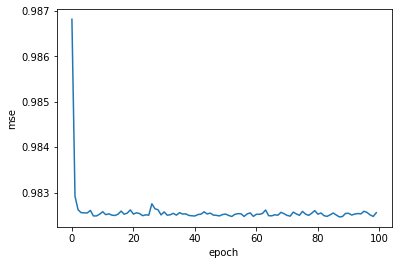

In [ ]:
LSTM3, TX3, TY3 = run_lstm(data_full,
                         len_seq=100, units=128, epochs=100, batch=64)

In [ ]:
PRED3 = np.sign(LSTM3(TX3, training=False).numpy().flatten())
print(np.sign(PRED3))
print(np.sum(PRED3 == TY3.flatten()) / len(PRED3))

[1. 1. 1. ... 1. 1. 1.]
0.5367686527106817


[result]: We can get a precision of 53.68% on test set.